<a href="https://colab.research.google.com/github/CeliaDiazSanchez/Data-Mining/blob/LAB05/LAB05_RINGS_Ana.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Enunciado

Se desea desarrollar un modelo predictivo para estimar la edad de un molusco utilizando tres bases de datos que contienen información sobre el sexo, longitud, diámetro, altura, peso total, peso desprendido, peso de las vísceras y peso de la concha del molusco. El objetivo es construir un modelo preciso que pueda predecir la edad del molusco basándose en estas características físicas.

¿Por qué es importante conocer el nº de anillos de un molusco?
A partir de los 3 anillos, estos aparecen periódicamente en la concha de los abulones. Se puede calcular su edad sumando 1.5 al nº de anillos.

**Aplicaciones reales**: saber la edad de un molusco puede ser muy útil. Cuando la policía se encuentra un arma, un cuerpo, droga, ... en el mar, y en ellos hay mejillones, calculando la edad de estos se puede averiguar cuanto tiempo lleva en el agua. Conociendo el tiempo y las corrientes también se puede determinar desde donde se tiró al mar, y mediante el registro de trafico marítimo de todos los barcos durante ese tiempo y en esa localización se puede averiguar el culpable.

También se utiliza, por investigadores para estudiar la relación entre el crecimiento y nutrientes en el agua. Los moluscos sirven como bioindicador de la calidad del agua, ya que los animales filtradores suelen ser sensibles a cambios en el medio. Si se quiere medir la contaminación de puertos, se puede utilizar la edad de los abulones para ello, ya que hay una relación directa, entre la presencia humana y el crecimiento de los moluscos, esto queda explicado más en detalle en: https://www.scielo.org.mx/scielo.php?script=sci_arttext&pid=S0185-38802003000100009

# Instalación paquetes

Instalamos la biblioteca "eli5" que nos ayuda a comprender como funcionan y toman las decisiones los modelos.

In [ ]:
!pip install eli5

# Instalación librerías y funciones

In [ ]:
from sklearn import metrics
import eli5
from eli5.sklearn import PermutationImportance
from sklearn.tree import DecisionTreeClassifier, export_text, plot_tree
from sklearn import metrics
from sklearn.model_selection import train_test_split, KFold, cross_val_score, RepeatedStratifiedKFold
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
import requests
import warnings
import pandas as pd
import numpy as np
import plotly.express as px
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import fpgrowth
from mlxtend.frequent_patterns import association_rules
import networkx as nx
import seaborn as sns
import matplotlib.pyplot as plt
warnings.filterwarnings('ignore')

# Creando un clasificador de árbol de decisión
def entrenar_modelo(x_train, x_test, y_train, y_test):
    modelo = DecisionTreeClassifier()
    # Entrenar el modelo
    modelo.fit(x_train, y_train)
    # Probar el modelo
    predicciones = modelo.predict(x_test)
    # Obtener las métricas
    exactitud = metrics.accuracy_score(y_test, predicciones)
    redondeada = round(exactitud * 100, 2)
    return redondeada


#Perform K folds splitting
def division_Kfolds(folds,x,y):
  KF = KFold(n_splits=folds)
  k = 1
  ltrain = []
  laccuracy = []
  # Este bucle itera sobre cada división generada por KF.split(x)
  for train, test in KF.split(x):
    x_train, x_test = x.iloc[train], x.iloc[test]
    y_train, y_test = y.iloc[train], y.iloc[test]
    accuracy = entrenar_modelo(x_train, x_test, y_train, y_test)
    ltrain.append(train)
    laccuracy.append(accuracy)
    k+=1
  print(f"La máxima precisión en {folds} divisiones es {max(laccuracy)} con k = {laccuracy.index(max(laccuracy))}")
  return ltrain, laccuracy, x_test, y_test


Leemos los archivos correspondientes.

In [ ]:
# URL del archivo CSV en GitHub
url = "https://raw.githubusercontent.com/CeliaDiazSanchez/Data-Mining/LAB05/abalone.csv"
nombre = 'abalone.csv'

url3 = "https://raw.githubusercontent.com/CeliaDiazSanchez/Data-Mining/LAB05/mix_abalone_train.csv"
nombre3 = 'mix_abalone_train.csv'

# Realizar la solicitud GET para obtener el contenido del archivo
response = requests.get(url)

# Verificar si la solicitud fue exitosa (código de estado 200)
if response.status_code == 200:
     # Guardar el contenido del archivo en un archivo local
    with open(nombre, 'wb') as f:
        f.write(response.content)
    print("Archivo descargado exitosamente.")
else:
    print("Error al descargar el archivo.")


# Realizar la solicitud GET para obtener el contenido del archivo
response = requests.get(url3)

# Verificar si la solicitud fue exitosa (código de estado 200)
if response.status_code == 200:
     # Guardar el contenido del archivo en un archivo local
    with open(nombre3, 'wb') as f:
        f.write(response.content)
    print("Archivo descargado exitosamente.")
else:
    print("Error al descargar el archivo.")


Archivo descargado exitosamente.
Archivo descargado exitosamente.


Para mayor fiabilidad de los modelos que vamos a crear, utilizamos 3 bases de datos de fuentes distintas, todas ellas recogen información sobre los abalones.

Cargamos los 2 archivos que usaremos a lo largo de la práctica como nuestra base de datos.

En este caso utilizaremos abalone y mix_abalone_train.

#### **Primera base de datos**

Recogida de https://archive.ics.uci.edu/dataset/1/abalone

> "From the original data examples with missing values were removed (the majority having the predicted value missing), and the ranges of the continuous values have been scaled for use with an ANN (by dividing by 200)."



(Es la misma que la primera pero con los datos escalados)


In [ ]:
df = pd.read_csv('abalone.csv')
# df_sorted = df.sort_values(by='Whole weight', ascending=True)
# Mostramos las 5 primeras entradas del dataset
df.head(5)

,Sex,Length,Diameter,Height,Whole weight,Shucked weight,Viscera weight,Shell weight,Rings
0,M,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.150,15
1,M,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.070,7
2,F,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.210,9
3,M,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.155,10
4,I,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.055,7


In [ ]:
df.shape

(4177, 9)

Tiene `4177 filas` y `9 columnas`

In [ ]:
df.describe()

,Length,Diameter,Height,Whole weight,Shucked weight,Viscera weight,Shell weight,Rings
count,4177.000000,4177.000000,4177.000000,4177.000000,4177.000000,4177.000000,4177.000000,4177.000000
mean,0.523992,0.407881,0.139516,0.828742,0.359367,0.180594,0.238831,9.933684
std,0.120093,0.099240,0.041827,0.490389,0.221963,0.109614,0.139203,3.224169
min,0.075000,0.055000,0.000000,0.002000,0.001000,0.000500,0.001500,1.000000
25%,0.450000,0.350000,0.115000,0.441500,0.186000,0.093500,0.130000,8.000000
50%,0.545000,0.425000,0.140000,0.799500,0.336000,0.171000,0.234000,9.000000
75%,0.615000,0.480000,0.165000,1.153000,0.502000,0.253000,0.329000,11.000000
max,0.815000,0.650000,1.130000,2.825500,1.488000,0.760000,1.005000,29.000000


#### **Segunda base de datos**

Recogida de ...
Contiene las siguientes variables, explicadas en el link anterior:

* **Sex**: M, F, and I (infant).
* **Length**: Longest shell measurement, measured in mm.
* **Diameter**: perpendicular to length, measured in mm.
* **Height**: with meat in shell, measured in mm.
* **Whole weight**:	whole abalone	measured in grams.
* **Shucked weight**: weight of meat measured in	grams.
* **Viscera weight**: gut weight (after bleeding), measured in grams.
* **Shell weight**: after being dried,	measured in grams.
* **Rings**: +1.5 gives the age in years

Tiene los datos escalados dividos entre 200 del original.

In [ ]:
df2 = pd.read_csv(nombre3)
# df_sorted3 = df3.sort_values(by='Height', ascending=False)
# Mostramos las 5 primeras entradas del dataset
df2.head(5)

,Sex,Length,Diameter,Height,Whole_weight,Shucked_weight,Viscera_weight,Shell_weight,Rings
0,F,0.550,0.430,0.150,0.7715,0.3285,0.1465,0.2400,11
1,F,0.630,0.490,0.145,1.1300,0.4580,0.2765,0.3200,11
2,I,0.160,0.110,0.025,0.0210,0.0055,0.0030,0.0050,6
3,M,0.595,0.475,0.150,0.9145,0.3755,0.2055,0.2500,10
4,I,0.555,0.425,0.130,0.7820,0.3695,0.1600,0.1975,9


In [ ]:
df2.shape

(94792, 9)

Tiene `94792 filas` o registros y `9 columnas` o atributos

In [ ]:
df2.describe()

,Length,Diameter,Height,Whole_weight,Shucked_weight,Viscera_weight,Shell_weight,Rings
count,94792.000000,94792.000000,94792.000000,94792.000000,94792.000000,94792.000000,94792.000000,94792.000000
mean,0.517402,0.401952,0.135643,0.790785,0.341597,0.169914,0.226468,9.707233
std,0.118308,0.098088,0.038193,0.459231,0.205267,0.101334,0.130639,3.178704
min,0.075000,0.055000,0.000000,0.002000,0.001000,0.000500,0.001500,1.000000
25%,0.445000,0.345000,0.110000,0.419500,0.177500,0.086500,0.120000,8.000000
50%,0.545000,0.425000,0.140000,0.799500,0.330000,0.166000,0.225000,9.000000
75%,0.600000,0.470000,0.160000,1.072500,0.464500,0.233000,0.305000,11.000000
max,0.815000,0.650000,1.130000,2.825500,1.488000,0.760000,1.005000,29.000000


Más adelante analizaremos los posibles outliers.

#### __Manipulación de las distintas bases de datos__

Los valores de ambas bases de datos tienen medidas estadísticas similares. Comprobamos que haya variedad de observaciones entre ambas bases de datos. Como `df` tiene menos registros que `df2`:

In [ ]:
# Contar cuántas filas de df están contenidas en df2
num_rows_in_df2 = df.isin(df2).all(axis=1).sum()

# Mostrar el resultado
print("Número de filas de df contenidas en df2:", num_rows_in_df2)

Número de filas de df contenidas en df2: 0


Esto es muy conveniente, ya que no queremos usar bases de datos que hayan utilizado las mismas observaciones, es decir, queremos que cada base de datos contenga medidas de abalones distintos.

Cambiamos los nombres de las columnas del segundo archivo, para eliminar errores de transcripción, como que haya una barras bajas "_" en vez de espacios.

In [ ]:
# Columnas del primer dataframe
df.columns

Index(['Sex', 'Length', 'Diameter', 'Height', 'Whole weight', 'Shucked weight',
       'Viscera weight', 'Shell weight', 'Rings'],
      dtype='object')

In [ ]:
# Columnas del segundo dataframe
df2.columns

Index(['Sex', 'Length', 'Diameter', 'Height', 'Whole_weight', 'Shucked_weight',
       'Viscera_weight', 'Shell_weight', 'Rings'],
      dtype='object')

In [ ]:
# Renombrar las columnas del segundo dataframe para que coincidan con las del primero
columnas = df.columns
df2.columns = columnas

Combinamos las bases de datos `df` y `df2` en una sola llamada `df_c` y guardamos esta base de datos en un nuevo archivo CSV llamado `df_c.csv`.

In [ ]:
# Combina las bases de datos
df_c = pd.concat([df, df2], ignore_index=True)

# Guarda la base de datos combinada en un nuevo archivo CSV
df_c.to_csv('df_c.csv', index=False)
df_c.head(5)

,Sex,Length,Diameter,Height,Whole weight,Shucked weight,Viscera weight,Shell weight,Rings
0,M,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.150,15
1,M,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.070,7
2,F,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.210,9
3,M,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.155,10
4,I,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.055,7


Como podemos observar en nuestra nueva base de datos, tenemos todos los datos en un solo archivo CSV.

Guardamos en una variable las características numéricas, para utilizarlas de manera más eficiente en códigos posteriores.

In [ ]:
numeric_cols = df_c.select_dtypes(include=['int', 'float'])

# Exploración y limpieza de la base de datos

####**Estudio de NaNs**

Comprobamos si hay algún NaN en nuestra base de datos.

In [ ]:
df_c.isna().sum()

Sex               0
Length            0
Diameter          0
Height            0
Whole weight      0
Shucked weight    0
Viscera weight    0
Shell weight      0
Rings             0
dtype: int64

No hay valores nulos en ninguna de las columnas de la base de datos combinada, ya que vemos que cada columna tiene 0 valores nulos, lo que significa que no falta ningún dato en ninguna de las variables.

#### **Dimensiones de la base de datos**

La base de datos combinada consta de un total de `98,969 registros`, cada uno con `9 atributos` y no encontramos valores nulos en ninguna de las columnas.


In [ ]:
df_c.shape

(98969, 9)

No obstante, calculamos y mostramos la cantidad de filas duplicadas, ya que las queremos eliminar para evitar un modelo impreciso debido a observaciones redundantes.

In [ ]:
# Filas Repetidas
filas_repetidas = df_c.duplicated().sum()
print("\nCantidad de Filas Repetidas:",filas_repetidas)


Cantidad de Filas Repetidas: 4177


Eliminamos las filas duplicadas de la base de datos combinada y luego mostramos la nueva forma del DataFrame para confirmar que las filas duplicadas han sido eliminadas.

In [ ]:
# Eliminamos filas duplicadas
df_c = df_c.drop_duplicates()

# Verificamos la nueva forma del DataFrame después de eliminar las filas duplicadas
print("Forma del DataFrame después de eliminar filas duplicadas:", df_c.shape)


Forma del DataFrame después de eliminar filas duplicadas: (94792, 9)


Tras la eliminación de los duplicados, el DataFrame resultante tiene:
$ 98.969 - 4.177 = 94.792 $ filas.

#### **Análisis de las variables**

En este apartado obtenemos los tipos de datos de cada columna en la base de datos combinada y los imprimimos.

In [ ]:
tipos_datos = df_c.dtypes
print("\nTipos de Datos:\n",tipos_datos)


Tipos de Datos:
 Sex                object
Length            float64
Diameter          float64
Height            float64
Whole weight      float64
Shucked weight    float64
Viscera weight    float64
Shell weight      float64
Rings               int64
dtype: object


* `float64` se usa para variables continuas como el diámetro y el peso.
* `int64` se usa para la variable que cuenta el número de anillos, ya que solo puede tomar valores enteros.
* `object` se usa para la variable que categoriza el sexo del abalón.



##### **Variable categórica**

Cuando pandas no puede inferir el tipo de datos correctamente, por defecto define la columna como tipo object, que es una categoría general que puede contener diversos tipos de datos, incluyendo cadenas de texto como es el caso.

En la descripción de la base de datos, vimos que `Sex` tomaba los valores 'M', 'F', 'I' para denotar male, female, infant respectivamente. Por lo que transformamos esta variable a tipo categórico.

In [ ]:
df_c['Sex'] = df_c['Sex'].astype('category')
# Verificar la transformación
print(df_c.dtypes[0])

category


A continuación veamos su distribución mediante la creación de un diagrama de barras usando `seaborn`.

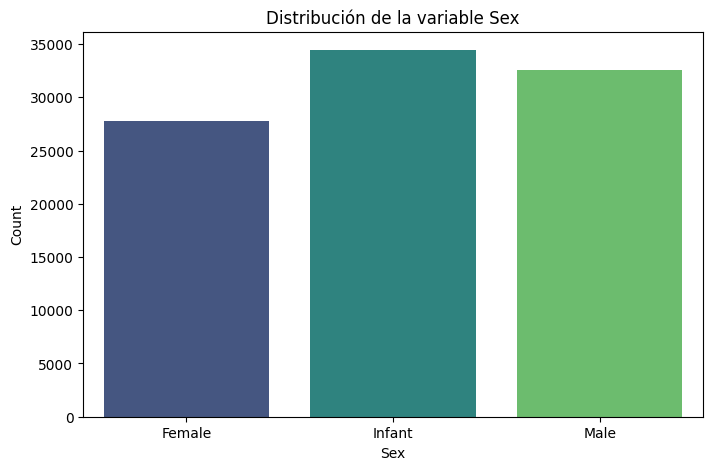

In [ ]:
# Crear la figura
plt.figure(figsize=(8, 5))

# Mapear los valores de la columna 'Sex' a etiquetas descriptivas solo para graficar
sex_labels = {'M': 'Male', 'F': 'Female', 'I': 'Infant'}
sns.countplot(x=df_c['Sex'].map(sex_labels), palette='viridis')

# Configuraciones del gráfico de barras
plt.title('Distribución de la variable Sex')
plt.xlabel('Sex')
plt.ylabel('Count')
plt.show()

Observamos que la mayoría de abalones son `infant` aunque no por mucha diferencia (aprox 5 mil infantes más).

##### **Variable objetivo**

Los anillos en los abulones son estructuras que se forman en sus caparazones a medida que crecen, de manera similar a los anillos de crecimiento en los árboles.

Según Chatgpt: en general, el número de anillos de un Haliotis corrugata adulto suele estar en el rango de 5 a 20 anillos.

In [ ]:
print("El abulón con más anillos del dataFrame tiene",df_c['Rings'].max(),"anillos, es decir," ,df_c['Rings'].max()+1.5,"años")

El abulón con más anillos del dataFrame tiene 29 anillos, es decir, 30.5 años


En el siguiento texto, se identifica que la edad máxima encontrada de manera natural fue de `20 años`. Por factores externos como la sobrepesca del reclutamiento, pueden desarrollarse abulones de hasta `25 años`.
> Nosotros encontramos en 1997 una edad máxima de 16 años para H. corrugata, mientras que Muñoz López (1976) reportó individuos de hasta 21 años antes de 1976, y Shepherd y Ávalos-Borja (1997) individuos de 18 años en 1970 para Isla Natividad, BCS, México, ambos usando la técnica de los anillos de la espira. Marín (1981), usando distribuciones de frecuencia de tallas, reporta un grupo de edad de 20 años.

> Una situación similar ocurre con H. fulgens. En este trabajo se encontró una edad máxima de 20 años, que es una cantidad menor de grupos de edad respecto a 1982 y 1985 cuando Turrubiates-Morales y Castro-Ortiz (1992) reportan, para la misma zona y usando la técnica del presente trabajo, individuos de hasta 25 años. Esta situación podría ser una evidencia de sobrepesca del reclutamiento, que sería la disminución de adultos de una manera tal que no se producen suficientes huevecillos para remplazar el reclutamiento. La pesca retira los organismos más viejos, que es una de las principales características de las poblaciones explotadas a niveles de intensidad importantes.

https://www.scielo.org.mx/scielo.php?script=sci_arttext&pid=S0185-38802003000100009

Queremos un modelo que pueda determinar la edad del abulón, incluso en zonas de sobrepesca, por lo que no eliminaremos valores que sobrepasen la vida media de un abulón. Es más, se le podría dar un nuevo enfoque al modelo, ya que si se encuentra un abulón extremadamente viejo, podría ser indicativo de que se encuentre en una zona explotada por la pesca de sus depredadores.

Sabemos que si se suma 1.5 al número de anillos, se obtiene la edad del molusco. Tomando como edad máxima 20 años, el número máximo de anillos lógico sería 18.5, redondeado a 19. Por ello eliminamos los valores mayores a 24 para la variable `Rings`

In [ ]:
# Recuento del número de registros con un número de anillos fuera del rango
greater_than_24 = (df_c['Rings'] > 19).sum()
print(greater_than_24 )

1246


Recordamos que el dataFrame tenía 94.792 filas, es decir, aproximadamente un 6% de las observaciones tienen un número de anillos extremo.Eliminamos esos registros.

In [ ]:
# Eliminar las observaciones con 'rings' mayor que 20
df_c = df_c[df_c['Rings'] <= 19]

Por otra parte, en el estudio anterior, se explica que la edad de estos animales se puede mediante sus anillos, a partir de 3 anillos. Ya que entonces, crecen periódicamente. Por ello, también eliminamos las observaciones con menos de 3 anillos.

In [ ]:
# Eliminar las observaciones con 'rings' menor que 3
df_c = df_c[df_c['Rings'] >= 3]

Descripción de la base de datos:

In [ ]:
df_c.describe()

,Length,Diameter,Height,Whole weight,Shucked weight,Viscera weight,Shell weight,Rings
count,93490.000000,93490.000000,93490.000000,93490.000000,93490.000000,93490.000000,93490.000000,93490.000000
mean,0.516175,0.400850,0.135098,0.784474,0.339936,0.168771,0.223869,9.554166
std,0.118307,0.097997,0.038026,0.456840,0.205292,0.101051,0.128643,2.872732
min,0.075000,0.055000,0.000000,0.002000,0.001000,0.000500,0.001500,3.000000
25%,0.445000,0.340000,0.110000,0.415500,0.175500,0.086000,0.120000,8.000000
50%,0.540000,0.425000,0.140000,0.790000,0.328500,0.164500,0.225000,9.000000
75%,0.600000,0.470000,0.160000,1.065000,0.462500,0.231500,0.304000,11.000000
max,0.815000,0.650000,1.130000,2.825500,1.488000,0.760000,1.005000,19.000000


##### **Variables numéricas**

Para analizar el resto de variables numéricas, y sus posibles outliers, hacemos uso de boxplots:

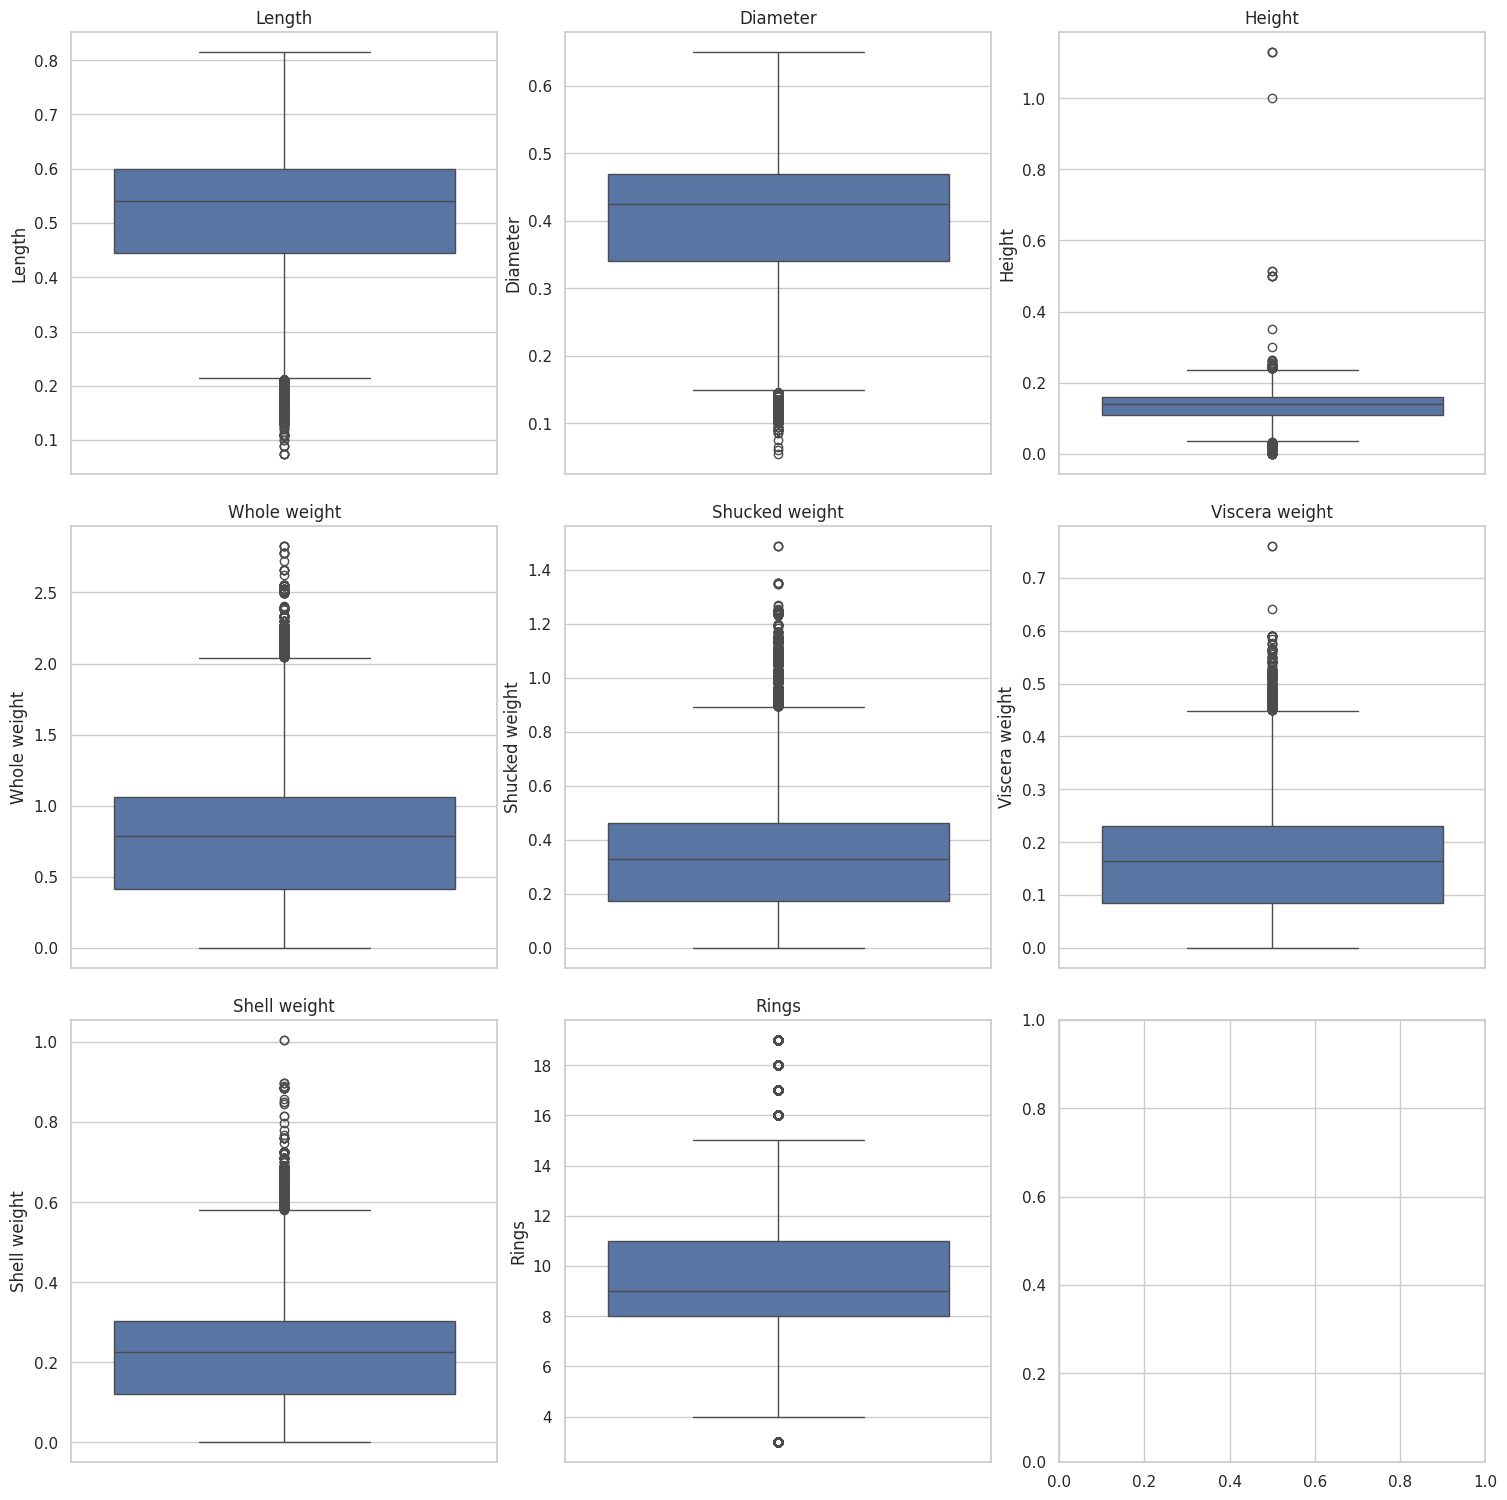

In [ ]:
# Configuración opcional para mejorar el aspecto de los gráficos
sns.set(style="whitegrid")

# Obtener el número de columnas en el dataframe
num_cols = len(numeric_cols)

# número de filas y columnas para los subplots
num_rows = 3
num_cols_subplot = 3

# Crear subplots
fig, axes = plt.subplots(num_rows, num_cols_subplot, figsize=(15, 5 * num_rows))

# Ajustar el diseño para evitar la superposición de etiquetas
plt.tight_layout()

# Crear boxplots para cada columna en el dataframe
for i, col in enumerate(numeric_cols):
      row_idx = i // num_cols_subplot
      col_idx = i % num_cols_subplot
      ax = axes[row_idx, col_idx] if num_rows > 1 else axes[col_idx]
      sns.boxplot(data=df_c[col], ax=ax)
      ax.set_title(col)

# Eliminar subplots no utilizados
for i in range(num_cols, num_rows * num_cols_subplot):
    row_idx = i // num_cols_subplot
    col_idx = i % num_cols_subplot
    ax = axes[row_idx, col_idx] if num_rows > 1 else axes[col_idx]
    fig.delaxes(ax)

# Mostrar los subplots
plt.show()


Hay outliers en todas las variables. Y hay demasiados de ellos como para eliminarlos, estaríamos perdiendo mucha información, es por ello que vamos a sustituir los outliers por los valores `upper bound` o `lower bound` de los boxplots. Es decir, por el valor de los cuartiles superior o inferior.

In [ ]:
# Iterar sobre cada columna numérica
for col in numeric_cols.drop(columns=['Rings']):
    # Calcular el rango intercuartil (IQR) de manera automática
    Q1 = df_c[col].quantile(0.25)
    Q3 = df_c[col].quantile(0.75)
    IQR = Q3 - Q1

    # Definir los límites para identificar outliers
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Reemplazar outliers por los valores del cuartil superior o inferior
    df_c[col] = df_c[col].apply(lambda x: upper_bound if x > upper_bound else lower_bound if x < lower_bound else x)


Una vez que las variables han sido limpiadas de outliers, creamos histogramas para identificar patrones de distribución.

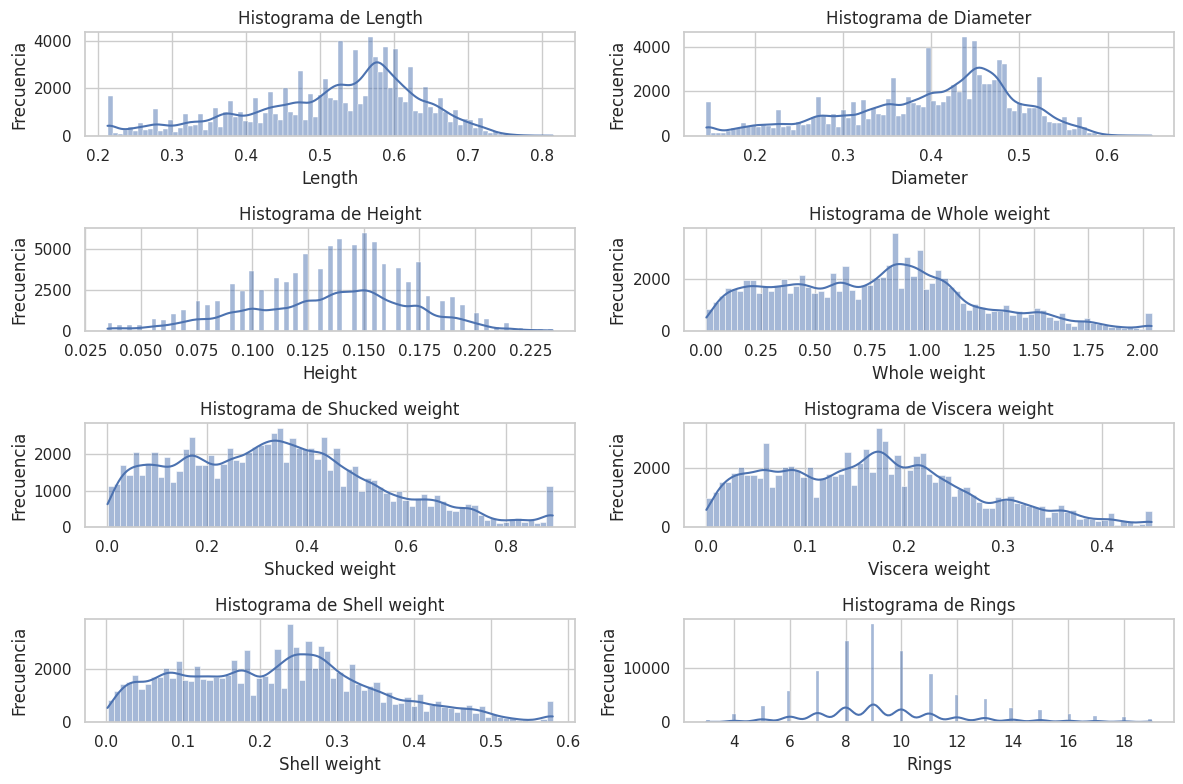

In [ ]:
# Configuración de tamaño de la figura
num_cols = len(numeric_cols.columns)
num_rows = (num_cols + 1) // 2  # Calcular el número de filas necesario
plt.figure(figsize=(12, 8))

# Iteración sobre las columnas para generar histogramas
for i, columna in enumerate(numeric_cols, 1):
    plt.subplot(num_rows, 2, i)
    sns.histplot(df_c[columna], kde=True)  # Utilizamos histplot en lugar de boxplot
    plt.title(f'Histograma de {columna}')
    plt.xlabel(columna)
    plt.ylabel('Frecuencia')

plt.tight_layout()
plt.show()

Variables que miden el peso, tienen, como es de esperar, distribuciones muy similares. Por otra parte observamos que la altura se mide de manera discreta, al igual que los anillos, para los que la mayoría de observaciones tiene entre 6 y 13 anillos.

In [ ]:
df_c['Height'].unique()

array([0.095 , 0.09  , 0.135 , 0.125 , 0.08  , 0.15  , 0.14  , 0.11  ,
       0.145 , 0.1   , 0.13  , 0.085 , 0.155 , 0.165 , 0.185 , 0.18  ,
       0.175 , 0.2   , 0.105 , 0.045 , 0.055 , 0.05  , 0.12  , 0.07  ,
       0.16  , 0.06  , 0.195 , 0.17  , 0.19  , 0.115 , 0.075 , 0.065 ,
       0.215 , 0.21  , 0.23  , 0.22  , 0.04  , 0.035 , 0.035 , 0.205 ,
       0.225 , 0.235 , 0.235 , 0.106 , 0.0615, 0.0735, 0.116 , 0.103 ,
       0.169 , 0.117 , 0.083 , 0.119 , 0.036 , 0.0915, 0.156 , 0.092 ,
       0.057 , 0.0825, 0.123 , 0.088 , 0.082 , 0.046 , 0.167 , 0.113 ,
       0.184 , 0.121 , 0.044 , 0.147 , 0.0925])

Debido al proceso llevado a cabo para eliminar outliers, los valores del cuartil superior e inferior de cada variable tendrán una mayor frecuencia.



##### **Correlaciones entre variables**

A continuación, calculamos de manera analítica las correlaciones entre variables.

In [ ]:
# Calcular la matriz de correlación
matriz_correlacion = numeric_cols.corr()

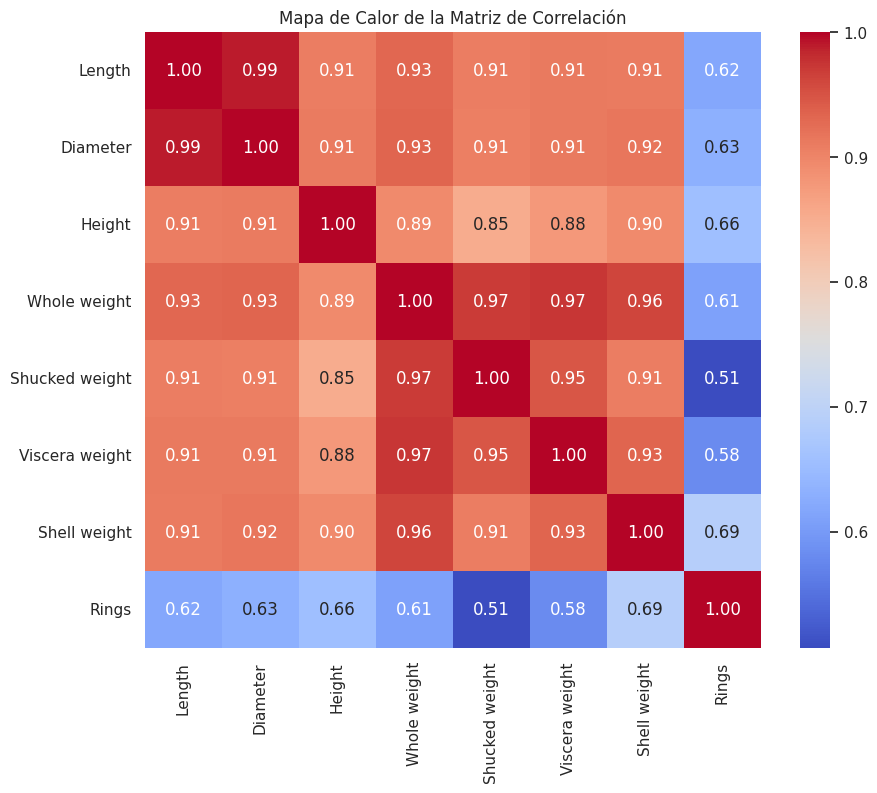

In [ ]:
# Crear un mapa de calor de la matriz de correlación
plt.figure(figsize=(10, 8))
sns.heatmap(matriz_correlacion, annot=True, cmap='coolwarm', fmt=".2f", square=True)
plt.title('Mapa de Calor de la Matriz de Correlación')
plt.show()

In [ ]:
# copia del dataFrame para poder hacer cambios sin afectar al original
df_clean = df_c.copy()

Hay altos niveles de correlación directa para todas las variables numéricas. Se explica de manera intuitiva, puesto que a mayor tamaño del abulón, mayor será su diámetro de concha, altura y pesos. Son variables que dependen unas de otras.

El sexo, sin embargo, no depende del resto de variables, es decir el tamaño y peso de los abulones no varía dependiendo del sexo.

---



Eliminamos las variables `Shucked weight`, `Viscera weight` y `Shell weight` puesto que son variables más costosas de medir que `Whole weight`. Así ahorramos al usuario tener que separar la concha de las visceras y de la carne, una tarea poco apetecible. Además, eliminando estas variables, se da la opción de devolver al mar al abulón, sin tener que matarlo en el proceso de tomar sus datos.

Por otra parte, aparece un nuevo enfoque, predecir la variable `Shucked weight`, para que restaurantes puedan conocer el peso exacto de la carne de los abulones que compran al por mayor.

\_Nota_\: El "shucked weight" es el peso de la carne comestible del abulón después de ser removido de su caparazón, mientras que el "viscera weight" es el peso de los órganos internos del abulón que no se consumen típicamente como alimento.

In [ ]:
df_clean = df_clean.drop(columns=['Shucked weight', 'Viscera weight', 'Shell weight'])



---



Eliminamos las variables `Diameter` y `Length` ya que también son más complicada de medir que la altura.

Según ChatGPT:
> El diámetro del abulón se mide como la distancia máxima entre dos puntos opuestos en su caparazón. Esta medida se toma con una regla o un calibrador, colocando el instrumento de medición en una posición perpendicular al caparazón del abulón y tomando la medida desde el borde exterior de un lado hasta el borde exterior del lado opuesto. Es importante asegurarse de tomar la medida en el punto más ancho del abulón para obtener una medida precisa del diámetro.

> La medida de "length" (longitud) del abulón se refiere a la distancia desde el extremo más largo del caparazón hasta el extremo opuesto. Se mide de manera similar al diámetro, tomando la medida desde el punto más alejado en un extremo del abulón hasta el punto más alejado en el extremo opuesto, siguiendo la curva del caparazón.

> La medida de "height" (altura) del abulón se refiere a la distancia vertical desde la base del caparazón hasta el punto más alto del mismo. Se puede medir colocando el abulón sobre una superficie plana y tomando la medida verticalmente desde la base hasta el punto más alto del caparazón.

In [ ]:
df_clean = df_clean.drop(columns=['Diameter','Length'])



---



Recordamos que este proyecto busca, no solo predecir características de los abulones, sino también facilitar el trabajo de biólogos, mayoristas y criadores de este animal. Por lo que evitamos utilizar variables cuya medición les requiera de más trabajo.

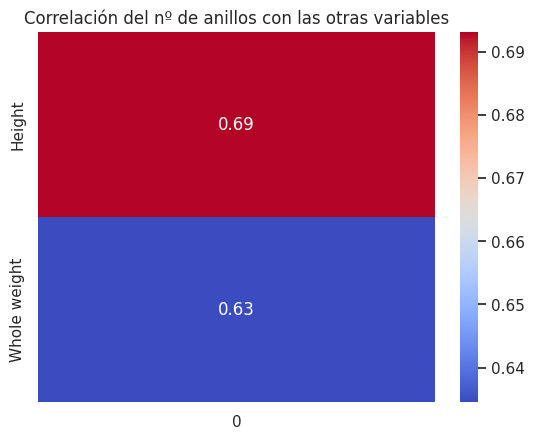

In [ ]:
# Calcula la matriz de correlación
rings_corr = df_clean.drop(columns=['Rings','Sex']).corrwith(df_clean['Rings'])

# Generar el mapa de calor utilizando Seaborn
sns.heatmap(rings_corr.to_frame(), annot=True, cmap='coolwarm', fmt=".2f")

# Añadir título
plt.title('Correlación del nº de anillos con las otras variables')

# Mostrar el gráfico
plt.show()

Las variables restantes `Whole weight` y `Height` tienen una correlación directa alta con la variable objetivo. Siendo la de la primera ligeramente más significativa.

Para analizar `sex` de manera adecuada, puesto que es una variable categórica, haremos un gráfico de dispersión en base a los anillos de cada categoría.

In [ ]:
df_clean['Sex'].unique()

['M', 'F', 'I']
Categories (3, object): ['F', 'I', 'M']

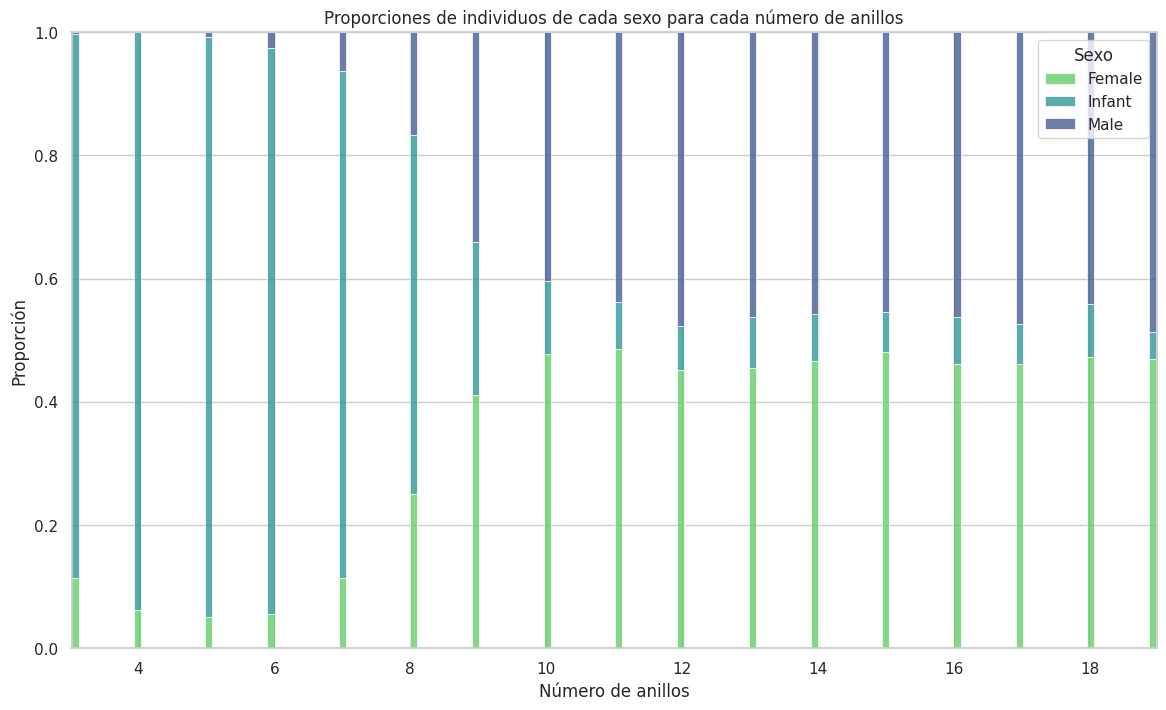

In [ ]:
# Crear un gráfico de barras apiladas con proporciones
plt.figure(figsize=(14, 8))
sns.histplot(data=df_clean, x='Rings', hue='Sex', multiple='fill', shrink=0.8, palette='viridis')

# Configuraciones del gráfico
plt.title('Proporciones de individuos de cada sexo para cada número de anillos')
plt.xlabel('Número de anillos')
plt.ylabel('Proporción')
plt.legend(title='Sexo', labels=['Female','Infant','Male'])
plt.show()

De esta manera podemos observar claramente como para menor nº de anillos (y consecuentemente menos edad), los abulones son infantes. Y según aumenta la edad, el sexo femenino y masculino se distribuyen en practicamente la misma proporción.

En conclusión, sí es una variable significativa en el estudio de anillos.

Otra manera de representarlo: (código sacado de https://www.kaggle.com/code/cardata/abalor-data-analysis-02)

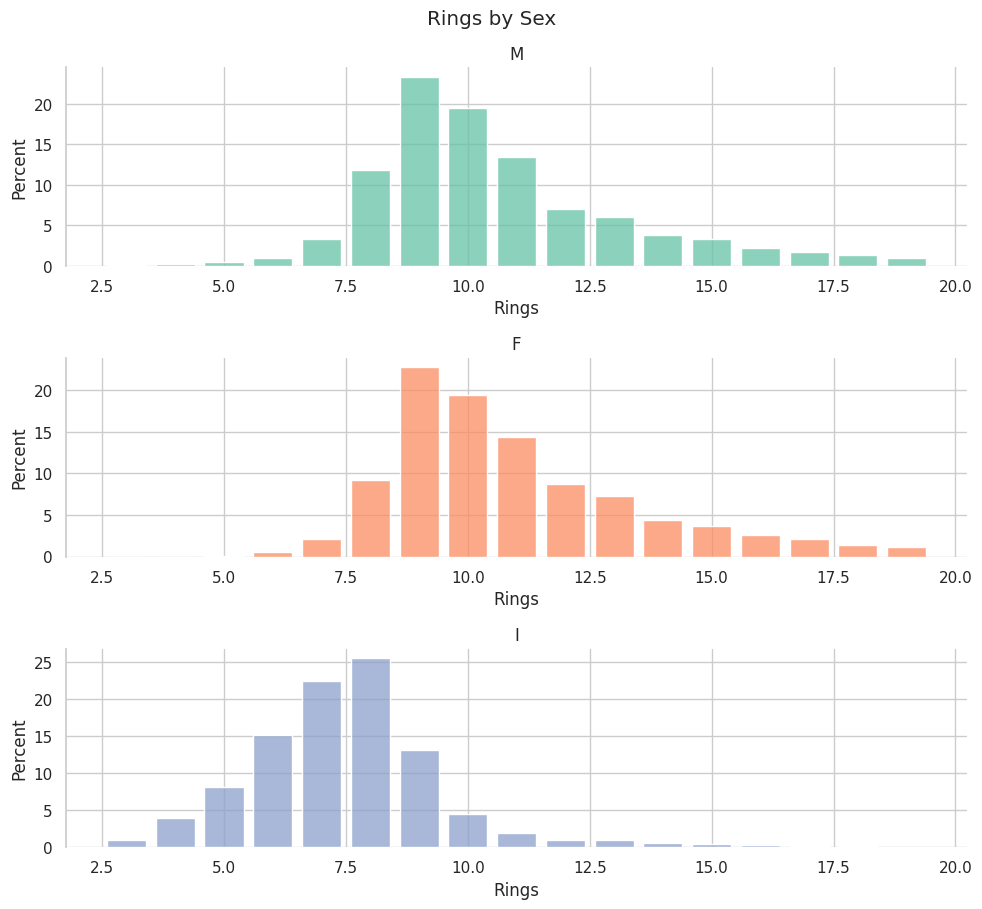

In [ ]:
def plot_dist_by_category(ser_values: pd.Series, ser_categories: pd.Series, title="") -> None:
    categories = ser_categories.unique()
    colors = sns.color_palette("Set2",len(categories)).as_hex()

    fig, axes = plt.subplots(nrows=len(categories),
                             ncols=1,
                             figsize=(10, len(categories)*2.3 + 2))
    axes = axes.flatten()

    for (ax, category, color) in zip(axes, categories, colors):

        sns.histplot(x=ser_values[ser_categories == category],
                     stat='percent',
                     discrete=True,
                     shrink=.8,
                     common_norm=False,
                     ax=ax,
                     color=color)
        ax.set_title(category)

    sns.despine(left=False, bottom=True)
    plt.tight_layout()
    fig.suptitle(title, y=1.02)
    plt.show()

plot_dist_by_category(df_c['Rings'], df_c['Sex'], 'Rings by Sex')



---



# Primer modelo: REGRESIÓN LINEAL

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, silhouette_score
from sklearn.cluster import KMeans
from sklearn.feature_selection import RFE
import scipy.stats as stats

## Una variable predictora: Height

Debido a la alta correlación entre `Height` y `Rings`, un modelo lineal simple que utilice la primera como variable predictora y la segunda como variable objetivo, podría dar una solución sencilla al problema de predicción.

In [ ]:
# Seleccionamos las variables predictoras
X_height = df_clean[['Height']]

# Seleccionamos la variable objetivo
y = df_clean[['Rings']]

# Dividimos los datos en conjuntos de entrenamiento y prueba
X_height_train, X_height_test, y_train, y_test = train_test_split(X_height, y, test_size=0.2, random_state=42)

__Nota__: los datos ya están escalados.

Creamos y ajustamos el modelo de regresión lineal para la variable **height**.

In [ ]:
model_height = LinearRegression()
model_height.fit(X_height_train, y_train)

LinearRegression()

Predecimos los valores de la variable objetivo en el conjunto de prueba

In [ ]:
y_pred_height = model_height.predict(X_height_test)

**Interpretación de resultados**

Al hacer una regresión lineal con una sola variable, estamos calculando lo siguiente:

$$ y = \beta_{0} + \beta_{1} \cdot\ x_{1} $$

Con:
- $y = $ variable objetivo `Rings`
- $\beta_{0} = $ intercepto
- $\beta_{1} = $ coeficiente de la variable predictora `Height`
- $x_{1} = $ variable predictora `HEight`

In [ ]:
print("El intercepto b0 es: ", model_height.intercept_)
print("El coeficiente b1 es: ", model_height.coef_)

El intercepto b0 es:  [2.32552954]
El coeficiente b1 es:  [[53.50181332]]


- El intercepto se encuentra en `2`, es decir, cuando la altura es cero, el nº de anillos es `2`. No obstante, que la altura sea 0 es surrealista.
- El coeficiente que acompaña a la variable de altura, es `56`, lo que indica una alta relación directa entre la altura y el nº de anillos. En concreto, por cada unidad que aumenta la altura, el nº de anillos aumenta en `56`. Hay que tener en cuenta que los datos introducidos al modelo deben están escalados, dividos entre 200, y que la altura de los abulones es reducida.



**Representación gráfica**


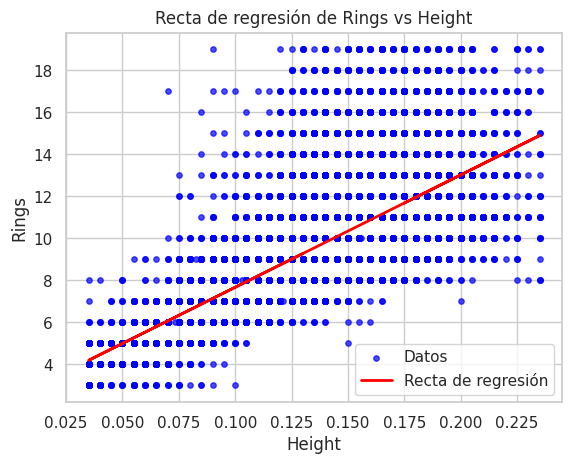

In [ ]:
# Graficar los puntos de datos
plt.scatter(X_height_test, y_test, color='blue', label='Datos',s=15,alpha = 0.7)

# Graficar la recta de regresión
plt.plot(X_height_test, y_pred_height, color='red', linewidth=2, label='Recta de regresión')

# Etiquetas y leyenda
plt.xlabel('Height')
plt.ylabel('Rings')
plt.title('Recta de regresión de Rings vs Height')
plt.legend()

# Mostrar la gráfica
plt.show()


- Los puntos azules son las observaciones, es decir cada registro de abulón.
- La recta roja es la recta de regresión calculada que mejor se ajusta a los puntos.

Observamos que la gran cantidad de datos genera ruido, haciendo difícil la obtención de una recta que se ajuste a ellos. Por otra parte, las observaciones se salen totalmente del espectro de puntos por el que puede pasar una recta.

Esto nos indica que la regresión lineal simple no es un buen modelo para una predicción de este tipo.


Igualmente calculamos la precisión y error del modelo para poder compararlo con modelos futuros.

Para calcular el error en el modelo obtenidos en el punto anterior, haremos uso del $ R^2 $ y el error cuadrático medio ($ MSE $).

$
R^2 = 1 - \frac{{\sum_{i=1}^{n} (y_i - \hat{y}_i)^2}}{{\sum_{i=1}^{n} (y_i - \bar{y})^2}}
$

Donde:
- $ n $ es el número de observaciones.
- $ y_i $ son los valores reales de la variable objetivo.
- $ \hat{y}_i $ son las predicciones del modelo para la variable objetivo.
- $ \bar{y} $ es la media de los valores reales de la variable objetivo.

Esta fórmula calcula el porcentaje de variabilidad en la variable objetivo que es explicada por el modelo de regresión.

$
MSE = \frac{1}{n} \sum_{i=1}^{n} (y_i - \hat{y}_i)^2
$

Donde:
- $ n $ es el número de observaciones.
- $ y_i $ son los valores reales de la variable objetivo.
- $ \hat{y}_i $ son las predicciones del modelo para la variable objetivo.

Esta fórmula calcula el promedio de los cuadrados de las diferencias entre los valores reales y las predicciones del modelo.

Para ello, primero calcularemos el rendimiento de cada variable en nuestro modelo.

In [ ]:
# height
mse_height = mean_squared_error(y_test, y_pred_height)
r2_height = r2_score(y_test, y_pred_height)
print("MSE:", mse_height)
print("R²:", r2_height)

MSE: 4.263559829111065
R²: 0.47721869065225186


Acorde con la gráfica obtenemos un valor reducido para R2 y bastante alto para MSE.

## Variables Height and Sex vs. Rings

La siguiente gráfica nos muestra que hacer una regresión lineal con variables dummies para cada categoría de `Sex` tampoco se ajustaría correctamente a los datos.

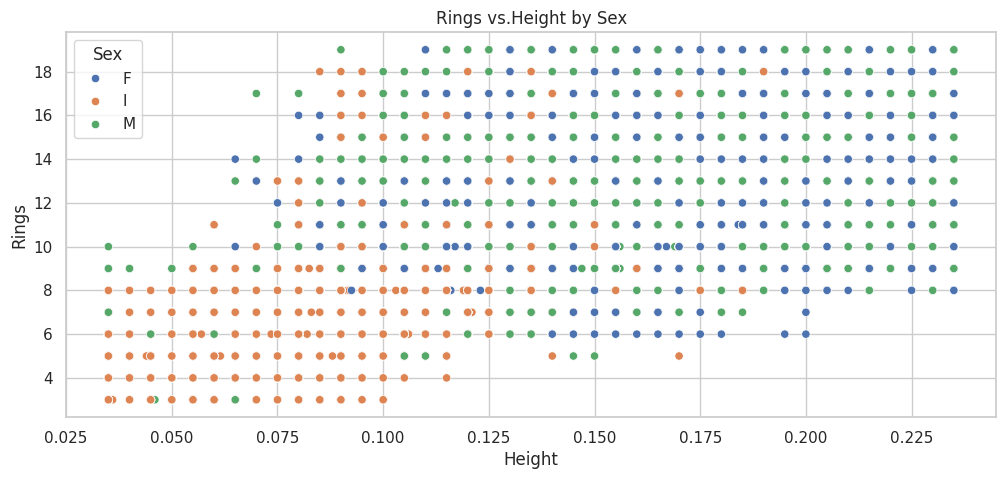

In [ ]:
plt.figure(figsize=(12, 5))
sns.scatterplot(data=df_clean, x='Height', y='Rings', hue='Sex')
plt.title('Rings vs.Height by Sex')
plt.xlabel('Height')
plt.ylabel('Rings')
plt.legend(title='Sex')
plt.show()

Aunque para `Infant` sí hay una relación, es decir, los infantes tienen menor nº de anillos cuando tienen menor altura. Para `Male` y `Female` no siguen un patrón concreto en cuanto a su nº de anillos respecto a su altura.

## Variables Height Weight Sex vs Rings

Por último intentaremos usar todas las variables de `df_clean` para predecir.

In [ ]:
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

X = df_clean[['Height', 'Whole weight', 'Sex']]

# Convertir la variable categórica 'quality' en variables dummy utilizando one-hot encoding
X = pd.get_dummies(X, columns=['Sex'], drop_first=True) # la primera dummy se elimina

# Seleccionar la variable objetivo
y = df_clean[['Rings']]

# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Creamos el modelo:

In [ ]:
# Crear y ajustar el modelo de regresión lineal
model = LinearRegression()
model.fit(X_train, y_train)

# Predecir los valores de la variable objetivo en el conjunto de prueba
y_pred = model.predict(X_test)

**Interpretación de resultados**


In [ ]:
print("El intercepto b0 es: ", model.intercept_)
print("Los coeficientes son:  ", model.coef_)

El intercepto b0 es:  [3.50268317]
Los coeficientes son:   [[49.65317193 -0.33892965 -0.95959067 -0.1114384 ]]


Que los coeficientes sean ceranos a cero indica que la variable no es significativa para la predicción. Denotamos que el mayor coeficiente es el asociado a la altura, seguido por el coeficiente de la variable "dummy" de `Infant`

In [ ]:
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print("MSE:", mse)
print("R²:", r2)

MSE: 4.1299506641348875
R²: 0.4936013326243873


El R ajustado mejora ligeramente y el MSE se reduce. Sin embargo esta mejora sigue sin ser suficiente para poder considerar al modelo como eficiente.

Debido a que el nº de anillos es una variable discreta, la podemos categorizar, y probar a usar modelos de clasificación como clústeres y árboles de decisión.



---



# Segundo modelo: ÁRBOL DE DECISIÓN

La variable del nº de anillos es una variable entera que podemos categorizar.

In [ ]:
anillos = sorted(list(df_c['Rings'].unique()),reverse=True)
print(anillos)

[19, 18, 17, 16, 15, 14, 13, 12, 11, 10, 9, 8, 7, 6, 5, 4, 3]


Además la vamos a agrupar según:

In [ ]:
# Definir los rangos y las etiquetas
bins = [0, 3, 7, 11, 16, float('inf')]
labels = [0, 1, 2, 3, 4]

# Aplicar la función cut para crear la nueva columna 'Rings_2'
df_clean['Rings_2'] = pd.cut(df_clean['Rings'], bins=bins, labels=labels, right=False)

`Sex` también debe tener etiquetas numéricas.

In [ ]:
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
df_clean['Sex'] = label_encoder.fit_transform(df_clean['Sex'])

Representamos en base a `Height`, `Whole weight` y `Sex` las agrupaciones de anillos.

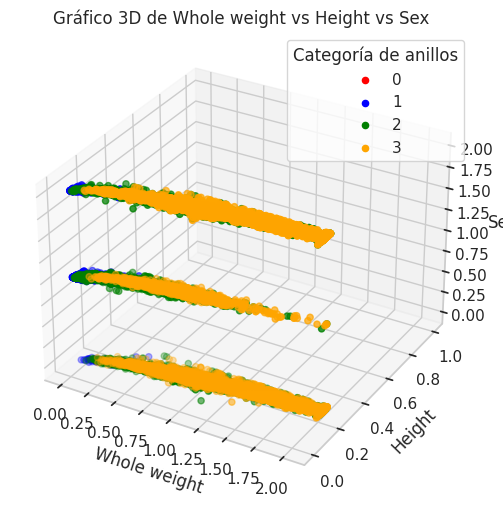

In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Crear un diccionario para mapear los colores a las categorías
category_colors = {0: 'red', 1: 'blue', 2: 'green', 3: 'orange'}

# Crear el gráfico 3D
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection='3d')

# Iterar sobre las categorías y trazar los puntos
for category, color in category_colors.items():
    subset = df_clean[df_clean['Rings_2'] == category]
    ax.scatter(subset['Whole weight'], subset['Height'], subset['Sex'], c=color, label=category)

# Agregar etiquetas y leyenda
ax.set_xlabel('Whole weight')
ax.set_ylabel('Height')
ax.set_zlabel('Sex')
ax.set_title('Gráfico 3D de Whole weight vs Height vs Sex')
ax.legend(title='Categoría de anillos')

# Mostrar el gráfico
plt.show()


No parece que las categorías de anillos sean facilmente agrupables mediante un cluster. Por ello, utilizaremos en su lugar, un árbol de decisión.

###Preparación de datos de train y test

Utilizaremos las variables `Height` y `Sex` como variables predictoras y `Rings_2` objetivo (que es la variable `Rings` pero discretizada).

In [ ]:
# Separar las características (variables independientes) de la variable objetivo
X = df_clean.drop(columns = ['Whole weight','Rings','Rings_2'], axis=1)  # Características
y = df_clean['Rings_2']  # Variable objetivo

# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Creación de los modelos ID3 y C4.5

Utilizan el criterio de entropía y de gini respectivamente.

In [ ]:
# Crear y entrenar el modelo de árbol de decisión con criterio de entropía
model_ID3 = DecisionTreeClassifier(criterion='entropy', random_state=42)
model_ID3.fit(X_train, y_train)

# Predecir en el conjunto de prueba
y_pred_ID3 = model_ID3.predict(X_test)

# Crear y entrenar el modelo de árbol de decisión con criterio de Gini
model_C45 = DecisionTreeClassifier(criterion='gini', random_state=42)
model_C45.fit(X_train, y_train)

# Predecir en el conjunto de prueba
y_pred_C45 = model_C45.predict(X_test)

### Resultados

In [ ]:
# Calcular la precisión
accuracy_ID3 = accuracy_score(y_test, y_pred_ID3)
accuracy_C45 = accuracy_score(y_test, y_pred_C45)

print("Precisión del modelo ID3:", accuracy_ID3)
print("Precisión del modelo C45:", accuracy_C45)

Precisión del modelo ID3: 0.6918386993261312
Precisión del modelo C45: 0.6918386993261312


Se obtienen unas precisiones de my similares, de aproximadamente 0.68 para ambos modelos. Es una mejora considerable respecto a la regresión lineal, sin embargo, no es lo suficientemente preciso.

### Gráficas

In [ ]:
from sklearn.tree import plot_tree

Representamos uno de los árboles de decisión creados.

* Modelo C4.5

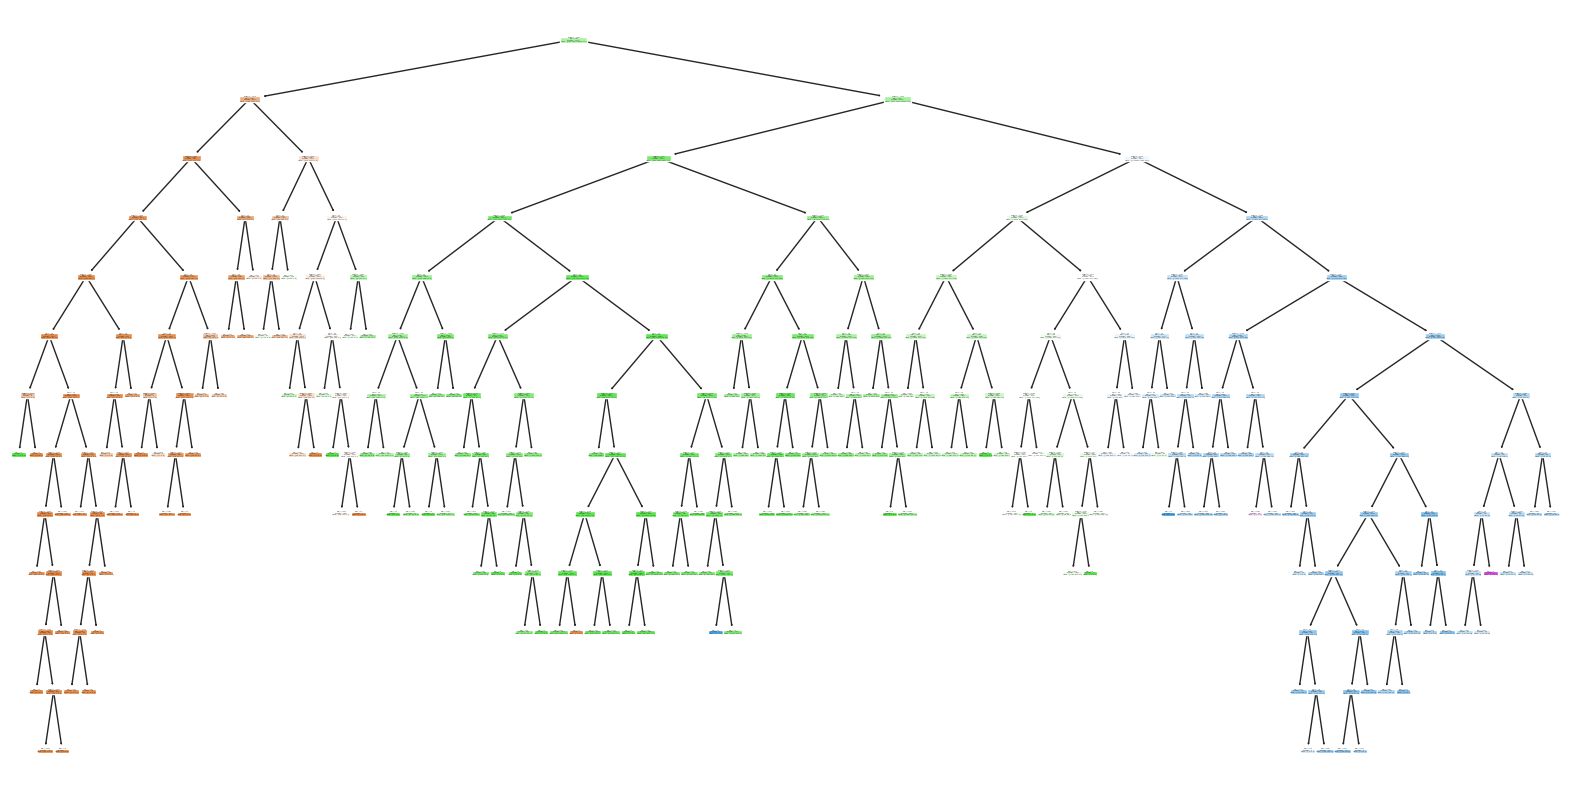

In [ ]:
plt.figure(figsize=(20, 10))
plot_tree(model_C45, filled=True, feature_names=X.columns)
plt.show()

Obtenemos un árbol bastante complejo, que no garantiza una precisión suficientemente alta, es por ello que realizamos las siguientes mejoras.



---



### Mejora del modelo:

Vamos a discretizar las variables usando `KBinsDiscretizer` para obtener agrupaciones regulares en las variables predictoras.

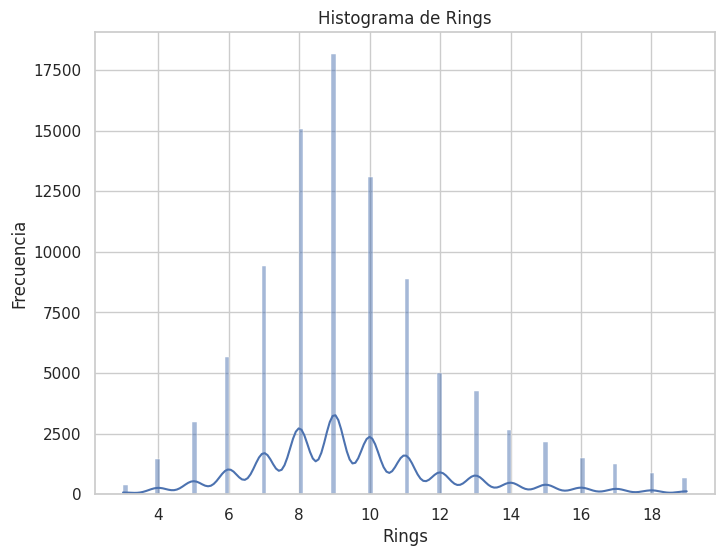

In [ ]:
# Configuración de tamaño de la figura
plt.figure(figsize=(8, 6))

# Histograma de la variable 'Rings'
sns.histplot(df_clean['Rings'], kde=True)
plt.title('Histograma de Rings')
plt.xlabel('Rings')
plt.ylabel('Frecuencia')

plt.show()

Un ejemplo del funcionamiento de `KBinsDiscretizer`:

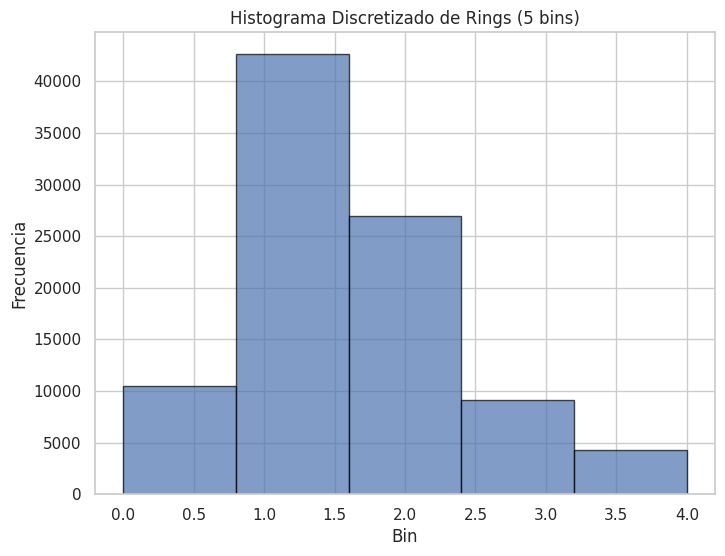

In [ ]:
n_bins = 5  # Número de bins deseado
discretizador = KBinsDiscretizer(n_bins=n_bins, encode='ordinal', strategy='uniform')

# Discretizar la variable 'Rings'
rings_discretizados = discretizador.fit_transform(df_clean['Rings'].values.reshape(-1, 1))

# Convertir la salida a un arreglo unidimensional
rings_discretizados = rings_discretizados.ravel()

# Configuración de tamaño de la figura
plt.figure(figsize=(8, 6))

# Histograma de los valores discretizados de 'Rings'
plt.hist(rings_discretizados, bins=n_bins, edgecolor='black', alpha=0.7)
plt.title(f'Histograma Discretizado de Rings ({n_bins} bins)')
plt.xlabel('Bin')
plt.ylabel('Frecuencia')

plt.show()

Variables como `Height` y `Whole weight` también pueden ser discretizadas para simplificar las operaciones. Concretamente nos interesa más `Height` ya que tiene una mayor correlación con la variable objetivo, y además tiene una distribución más uniforme como se muestra en la siguiente gráfica.

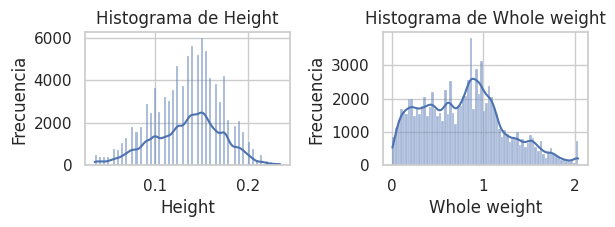

In [ ]:
plt.figure(figsize=(24, 8))

# Iteración sobre las columnas para generar histogramas
for i, columna in enumerate(['Height','Whole weight'], 1):
    plt.subplot(num_rows, num_cols, i)
    sns.histplot(df_clean[columna], kde=True)
    plt.title(f'Histograma de {columna}')
    plt.xlabel(columna)
    plt.ylabel('Frecuencia')

plt.tight_layout()
plt.show()

Observamos que `Height` ya está discretizada, de manera que las observaciones toman uno de entre 69 posibilidades de altura.

In [ ]:
df_clean['Height'].unique().size

69

Elegimos las variables predictoras `Height` y `Sex` para predecir `Rings_2` que son el nº de anillos discretizados.

In [ ]:
# Seleccionamos las variables
df_discrete = df_clean[['Height','Rings_2','Sex']]

A continuación, preparamos los datos para el modelo.

In [ ]:
x = df_discrete.drop(columns=['Rings_2'])  # Variables independientes
y = df_discrete["Rings_2"]

Ejecutamos el entrenamiento y evaluación del modelo de árbol de decisión para distintos folds.

In [ ]:
folds = [10, 100, 200, 500, 700, 1100, 1500, 2000]
accuracies = []
for i in folds:
    _, accuracy, _, _ = division_Kfolds(i, x, y)
    accuracies.append(max(accuracy))


La máxima precisión en 10 divisiones es 69.84 con k = 8
La máxima precisión en 100 divisiones es 73.9 con k = 27
La máxima precisión en 200 divisiones es 76.28 con k = 11
La máxima precisión en 500 divisiones es 78.61 con k = 14
La máxima precisión en 700 divisiones es 82.84 con k = 11
La máxima precisión en 1100 divisiones es 89.41 con k = 18
La máxima precisión en 1500 divisiones es 92.06 con k = 24
La máxima precisión en 2000 divisiones es 95.74 con k = 23


Graficamos las precisiones obtenidas.

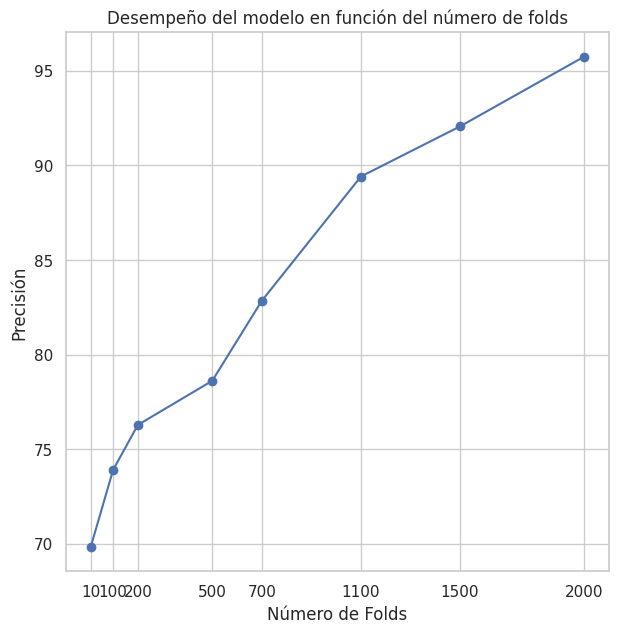

In [ ]:
# Graficar el desempeño en función del número de folds
plt.figure(figsize=(7, 7))
plt.plot(folds, accuracies, marker='o', linestyle='-')
plt.title('Desempeño del modelo en función del número de folds')
plt.xlabel('Número de Folds')
plt.ylabel('Precisión')
plt.grid(True)
plt.xticks(folds)
plt.show()

A partir de 1500 folds consideramos que se tiene una precisión suficiente, ya que es demasiado costoso computacionalmente, aumentar el nº de folds.

In [ ]:
ltrain, laccuracy, x_test, y_test = division_Kfolds(1500, x, y)

La máxima precisión en 1500 divisiones es 92.06 con k = 24


In [ ]:
# Escogemos la mejor división (1500)
max_index = laccuracy.index(max(laccuracy))
model = DecisionTreeClassifier()
model.fit(x.iloc[ltrain[max_index]], y.iloc[ltrain[max_index]])
print("Visualización de atributos relacionadas con los Rings predichos")
permutacion = PermutationImportance(model, random_state = 0).fit(x_test, y_test)

Visualización de atributos relacionadas con los Rings predichos


In [ ]:
# Generar la tabla con el color de fondo personalizado
html_table = eli5.show_weights(permutacion, feature_names=x_test.columns.tolist()).data

# Cambiar el color de fondo de la tabla
html_table = html_table.replace('<table ', '<table style="background-color: #FFA500;" ')

# Mostrar la tabla HTML
from IPython.display import HTML
HTML(html_table)

Weight,Feature
0.2645 ± 0.0664,Height
0.0258 ± 0.0329,Sex
